# Summary
This notebok gives some examples for how to use [GeoPandas](https://geopandas.org/en/stable/docs/user_guide.html) and the data loading utility modules in the `src` directory.

In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from src.datasets.loading import statcan, ookla

## Geopandas
To start, geopandas uses matplotlib as a plotting backend by default. It also has some basic data to load. 

In [3]:
#Geopandas is like pandas, but has a special "geometry" 
#column and special support for geometric operations with this column
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
cities = gp.read_file(gp.datasets.get_path('naturalearth_cities'))
world.head(2)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


<AxesSubplot: >

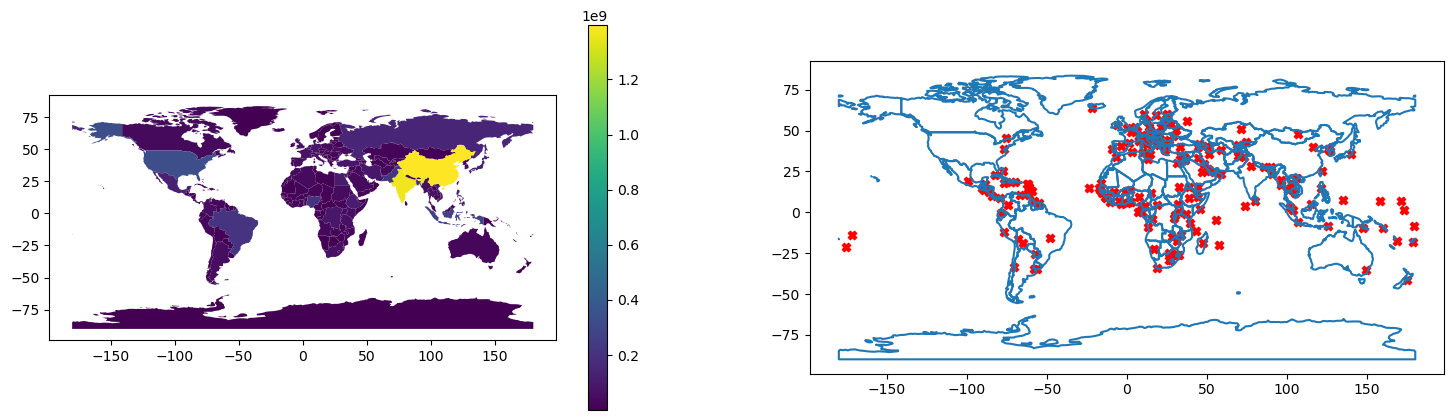

In [4]:
# Specifically the plotting is somewhat sophisticated,
# with support for chloropeth maps
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))
world.plot(column=world.pop_est, legend=True, ax=ax1)
world.boundary.plot(ax=ax2)
cities.plot(marker='X', color='red', ax=ax2)

## Basic Plotting of Tiles + Statistics Canda Shapefiles
To show some utility and make a graph where you can actually see the tiles individually, 
below is an example of some of the things you can do with GeoPandas.

In [5]:
## Statcan Data: list names of available shapefiles
statcan.boundary_names()

['provinces',
 'provinces_digital',
 'federal_electoral_districts_2013_representation_order',
 'economic_regions',
 'census_divisions',
 'population_centres',
 'population_ecumene',
 'dissemination_areas',
 'dissemination_blocks',
 'census_subdivisions',
 'designated_places',
 'lakes_and_rivers_polygons']

In [6]:
speed_tiles = ookla.canada_speed_tiles().loc[lambda s:(s.quarter==1) & (s.year==2022)]

In [7]:
#Use a buffer to increase Calgary size, envelope creates a bounding box for use later.
calgary_area = statcan.boundary('population_centres').loc[lambda s:s.PCNAME=='Calgary'].copy()
calgary_area.geometry = calgary_area.buffer(50000).envelope #The StatCan CRS is in units of meters, so this is all tiles within 50 km of Calgary

In [8]:
nearby_census_subdivs = statcan.boundary('census_subdivisions').sjoin(calgary_area[['PCNAME','PCTYPE','PCCLASS','geometry']], how='inner')
del nearby_census_subdivs['index_right']
nearby_census_subdivs.sample(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,PCNAME,PCTYPE,PCCLASS
4555,4806014,Rocky View County,MD,48,Alberta,4806,Division No. 6,CDR,4806014,Rocky View County,...,825,1,825,48825,Calgary,B,"POLYGON ((4666222.751 1976893.989, 4666543.574...",Calgary,1,4
3964,4806022,Irricana,T,48,Alberta,4806,Division No. 6,CDR,4806014,Rocky View County,...,825,1,825,48825,Calgary,B,"POLYGON ((4727585.834 1941149.537, 4727574.634...",Calgary,1,4
4557,4806017,Chestermere,CY,48,Alberta,4806,Division No. 6,CDR,4806014,Rocky View County,...,825,1,825,48825,Calgary,B,"POLYGON ((4702675.054 1917374.454, 4702669.209...",Calgary,1,4


<AxesSubplot: >

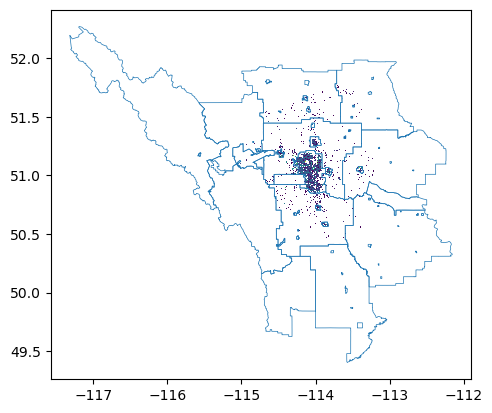

In [9]:
## the spatial join against the much wider areas of the census subdivisions 
## causes the default plotting area to be much wider than anticipated with the 
## calgary area geoemtry
nearby_speeds = speed_tiles.sjoin(calgary_area.to_crs('epsg:4326'), how='inner') #epsg:4326
ax = nearby_speeds.plot(column='avg_d_kbps')
nearby_census_subdivs.to_crs('epsg:4326').boundary.plot(ax=ax, linewidth=0.5)


### Census Info
Also some census data is available on populations.

In [10]:
subdiv_pops = statcan.census_subdivisions_populations()
subdiv_pops.DAPOP = pd.to_numeric(subdiv_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
subdiv_pops

/Users/zacharyshand/ookla-statcan-analysis/notebooks/../src/datasets/loading/statcan.py:234: DtypeWarning: Columns (3,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(POP_FILE)


,CSDUID,GEO_NAME,DAPOP
381,1001105,"Portugal Cove South, T",150.0
635,1001113,"Trepassey, T",485.0
1016,1001120,"St. Shott's, T",65.0
1270,1001124,"Division No. 1, Subd. U, SNO",1625.0
1778,1001126,"Cape Broyle, T",490.0
...,...,...,...
7605014,6208047,"Kugaaruk, HAM",935.0
7605268,6208059,"Kugluktuk, HAM",1490.0
7605649,6208073,"Cambridge Bay, HAM",1770.0
7606157,6208081,"Gjoa Haven, HAM",1325.0


<AxesSubplot: >

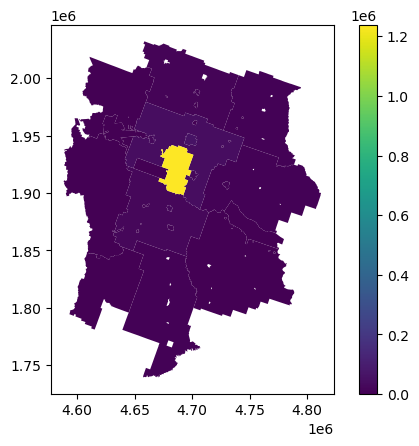

In [11]:
nearby_census_subdivs.CSDUID = nearby_census_subdivs.CSDUID.astype(int) ## coerce ID type to fully int instead of object
nearby_census_subdivs.merge(subdiv_pops, on='CSDUID', validate='1:1').plot(column='DAPOP', vmin=0, categorical=False, legend=True)

## Calculate Statistics

In [12]:
census_divs_speeds = statcan.boundary('census_divisions').to_crs('epsg:4326').sjoin(speed_tiles, how='left')

In [13]:
divs_pops = statcan.census_divisions_populations()
divs_pops.DAPOP = pd.to_numeric(divs_pops.DAPOP, errors='coerce') #certain subdivisions have data flags instead of values
divs_pops


,CDUID,GEO_NAME,DAPOP
254,1001,Division No. 1,270345.0
72644,1002,Division No. 2,20375.0
83820,1003,Division No. 3,15560.0
92075,1004,Division No. 4,20385.0
99568,1005,Division No. 5,42015.0
...,...,...,...
7589774,6105,Region 5,6980.0
7592441,6106,Region 6,20090.0
7597775,6204,Baffin,18985.0
7602347,6205,Keewatin,10415.0


In [14]:
census_speeds_agg = (census_divs_speeds.groupby('CDUID')['avg_d_kbps'].mean()/1000).rename('avg_d_mpbs')

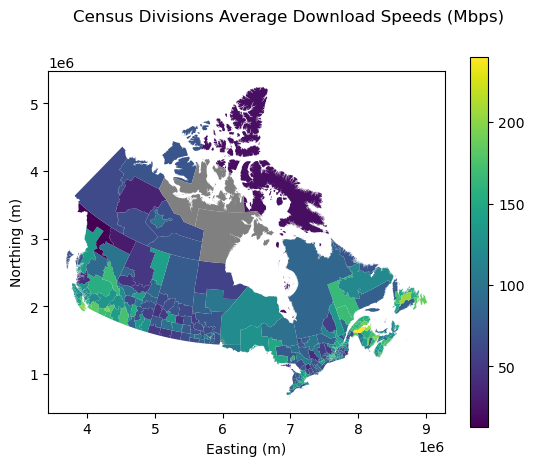

In [17]:
statcan.boundary('census_divisions').merge(census_speeds_agg, left_on="CDUID", right_index=True).plot(column='avg_d_mpbs', legend=True, missing_kwds={'color':'gray'})
plt.gcf().suptitle("Census Divisions Average Download Speeds (Mbps)")
plt.gca().set(xlabel="Easting (m)", ylabel="Northing (m)");